# Titanic - Machine Learning from Disaster
## Start here! Predict survival on the Titanic and get familiar with ML basics

Overview

The data has been split into two groups:

    training set (train.csv)
    test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns 

sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from numpy.random import choice
from collections import Counter
import itertools

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, KernelPCA
from imblearn.over_sampling import ADASYN
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

from imblearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

Populating the interactive namespace from numpy and matplotlib


In [2]:


# function to plot confusion matrix
def vis_conf_matrix(conf_martix, model_name):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_martix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_martix.flatten()/np.sum(conf_martix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _, ax = plt.subplots(figsize = (6,6))
    ax = sns.heatmap(conf_martix, annot=labels, fmt = '', 
                     annot_kws = {"size": 20, "weight": "bold"}, cmap = 'Blues')  
    labels = ['False', 'True']
    ax.set_title('Confusion Matrix for {}'.format(model_name), fontsize = 15)
    ax.set_xticklabels(labels, fontsize = 10)
    ax.set_yticklabels(labels, fontsize = 10)
    ax.set_xlabel('Prediction', fontsize = 15)
    ax.set_ylabel('Ground Truth', fontsize = 15)



In [3]:
# define function that fits clustering model and returns data + clustering labels column
def agg_cluster(data, n_clusters, linkage = 'ward'):
    if n_clusters <= 0:
        return data
    else:
        agg = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)
        new_col = agg.fit_predict(data)
        new_col = new_col.reshape(len(new_col), 1)
        data = np.append(data, new_col, axis=1)
        return data

In [4]:
# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
print("Train data size: ", train_data.shape)
print("Train data: ", train_data.columns.tolist())
print("-" * 40)
print("Test data size: ", test_data.shape)
print("Test data: ", test_data.columns.tolist())
print("-" * 40)
train_data.head()

Train data size:  (891, 12)
Train data:  ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
----------------------------------------
Test data size:  (418, 11)
Test data:  ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
----------------------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# PART I: Cleaning data

Columns with NA values:

    in train data: Age, Cabin, Embarked
    in test data: Age, Fare, Cabin

Cleaning data

Check for:

    Duplicates
    Data formats, typos
    Missing values



In [7]:
# check for duplicate rows on Name
duplicate_train = train_data[train_data.duplicated(['Name'])]
duplicate_test = test_data[test_data.duplicated(['Name'])]

print("Duplicate rows in Name column (train data): ", len(duplicate_train))
print(f"PassengerId column in train data: {train_data.PassengerId.nunique()} unique values out of {len(train_data.PassengerId)}")
print("Duplicate rows in Name column (test data): ", len(duplicate_test))
print(f"PassengerId column in test data: {test_data.PassengerId.nunique()} unique values out of {len(test_data.PassengerId)}")

Duplicate rows in Name column (train data):  0
PassengerId column in train data: 891 unique values out of 891
Duplicate rows in Name column (test data):  0
PassengerId column in test data: 418 unique values out of 418


=> No duplicates in the Name column, all Passenger IDs are unique.


In [9]:
# calculate how many missing values
missing_values_count_train = train_data.isnull().sum()
missing_values_count_test = test_data.isnull().sum()
print("Train data:\n", missing_values_count_train)
print('-'*40)
print("Test data:\n", missing_values_count_test)

Train data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------
Test data:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Plan for data cleaning and feature engineering:

    Impute NAs in:
        Age column - with median age within the group (possible groups: sex, pclass)
        Embarked column in the train data - with top value
        Fare column in the test data - with median value within the pclass
    Look closer into Cabin values:
        How many unique values?
        Can we split cabins into categories?
        Can we use missing values as its own ctegory?
    Look closer into Ticket values:
        How many unique values?
        Can we split tickets into categories?
        What could we learn from it?
    PassengerId and Name columns carry little useful information for model to learn.
        Can we extract titles from Name and build categories based on them?
    What can we do with SibSp and Parch columns?
        SibSp (integer)

            number of siblings or spouses aboard the Titanic
            Sibling = brother, sister, stepbrother, stepsister
            Spouse = husband, wife (mistresses and fiancés were ignored)

        Parch (integer)

            number of parents or children aboard the Titanic
            Parent = mother, father
            Child = daughter, son, stepdaughter, stepson
            Some children travelled only with a nanny, therefore parch=0 for them.

        Can we create FamilySize column? (FamilySize = SibSp + Parch + 1)

Imputing NAs
Age column


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

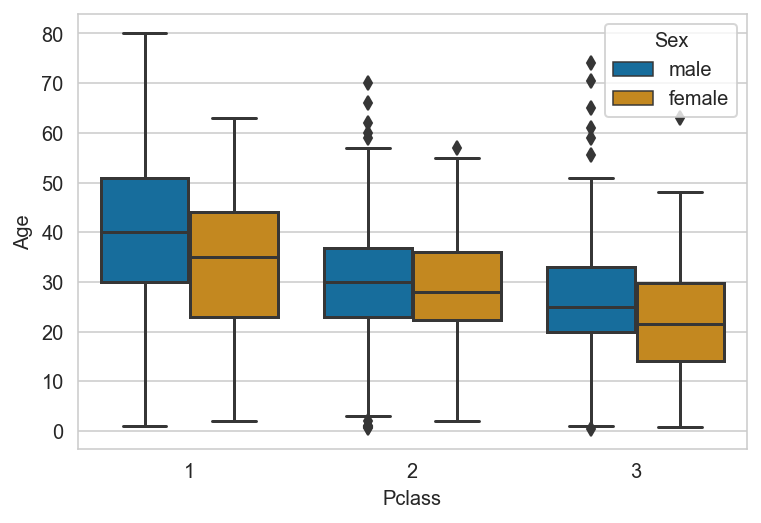

In [10]:
# Plot age distribution according to groups by sex and Pclass
sns.boxplot(y = 'Age', x = 'Pclass',
           data = train_data,
           palette = 'colorblind',
           hue = 'Sex')

In [11]:
# Calculate guess_age matrix for train data to later impute into both train and test datasets
guess_age = np.zeros((2,3))
sex = ['male', 'female']

for i in range(0, 2):
    for j in range(0, 3):
        guess_age[i,j] = int(train_data[(train_data['Sex'] == sex[i]) 
                                        & (train_data['Pclass'] == j + 1)]['Age']
                            .dropna()
                            .median())
guess_age

array([[40., 30., 25.],
       [35., 28., 21.]])

In [12]:
# Copy train data into new data frame
train1 = train_data.copy()
test1 = test_data.copy()
datasets = [train1, test1]

In [13]:
# Impute NAs in Age with guess_age
for dataset in datasets:
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == sex[i]) 
                        & (dataset.Pclass == j + 1), 'Age'] = guess_age[i,j]
            
print("Train data Age NAs: ", train1.Age.isnull().sum())
print("Test data Age NAs: ", test1.Age.isnull().sum())

Train data Age NAs:  0
Test data Age NAs:  0


####  Embarked and Fare columns


In [14]:
# Impute NAs in Embarked column of the train dataset with the most frequent value (mode value)
train1['Embarked'].fillna(train1['Embarked'].mode()[0], inplace = True)
print("Train data Embarked NAs: ", train1.Embarked.isnull().sum())

Train data Embarked NAs:  0


<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

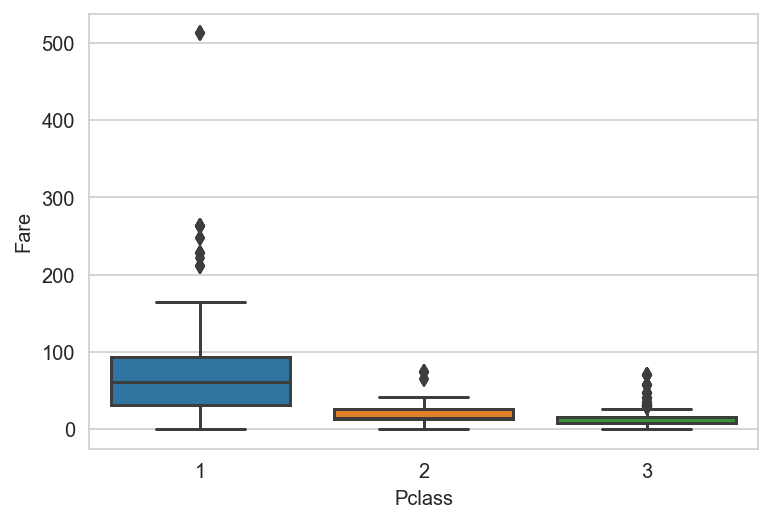

In [15]:
# Plot Fare distribution according to groups Pclass
sns.boxplot(y = 'Fare', x = 'Pclass',
           data = train1)

In [16]:
# Find a Pclass value for the NA in the test data
NA_pclass = int(test1[(test1.Fare.isnull())]['Pclass'])
print("Pclass of NA value in the test data: ", NA_pclass)

# Calculate median value for the Fare within that pclass
fare_to_impute = train1[(train1['Pclass'] == NA_pclass)]['Fare'].median()
print("Median value to impute: ", fare_to_impute)

Pclass of NA value in the test data:  3
Median value to impute:  8.05


In [17]:
# Impute NAs in Fare column of the train dataset with the median value within the pclass
test1['Fare'].fillna(fare_to_impute, inplace = True)
print("Test data Fare NAs: ", test1.Fare.isnull().sum())

Test data Fare NAs:  0


In [18]:
# Check again for NAs
print("Train data:\n", train1.isnull().sum())
print('-'*40)
print("Test data:\n", test1.isnull().sum())

Train data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
----------------------------------------
Test data:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [19]:
print("Unique cabin numbers for train data:\n", train1.Cabin.unique())
print("Total: ", train1.Cabin.nunique())
print("-"*40)
print("Unique cabin numbers for test data:\n", test1.Cabin.unique())
print("Total: ", test1.Cabin.nunique())

Unique cabin numbers for train data:
 [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']
Total


# PART II : Visualizing data

Let's drop columns that we won't use anymore (except PassengerId, I will leave it for now):

    Name
    Ticket
    Cabin
    Deck
    Ticket_new



In [23]:


# columns to drop defenetly
to_drop = ['Name', 'Ticket',  'Cabin']
train2 = train1.copy().drop(to_drop, axis=1)
test2 = test1.copy().drop(to_drop, axis=1)
datasets2 = [train2, test2]

for dataset in datasets2:
    print(dataset.info())
    print('-'*40)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age   

In [24]:
# fix data type for PassengerId
for dataset in datasets2:
    dataset['PassengerId'] = dataset['PassengerId'].astype('object')

# split columns into numerical and categorical (exclude the PassengerId)
float_cols = train2.drop('PassengerId', axis=1).dtypes[train2.dtypes == 'float64'].index.tolist()
int_cols = train2.drop('PassengerId', axis=1).dtypes[train2.dtypes == 'int64'].index.tolist()
cat_cols = train2.drop('PassengerId', axis=1).dtypes[train2.dtypes == 'object'].index.tolist()
num_cols = float_cols + int_cols
binary = [x for x in num_cols if len(train2[x].unique()) == 2]
num_not_binary = [x for x in num_cols if x not in binary]

print("Numerical variables: ", num_cols)
print("Numerical continuous variables: ", float_cols)
print("Numerical discrete variables: ", int_cols)
print("Numerical and not binary variables: ", num_not_binary)
print("Binary variables: ", binary)
print("Categorical variables: ", cat_cols)

Numerical variables:  ['Age', 'Fare', 'Survived', 'Pclass', 'SibSp', 'Parch']
Numerical continuous variables:  ['Age', 'Fare']
Numerical discrete variables:  ['Survived', 'Pclass', 'SibSp', 'Parch']
Numerical and not binary variables:  ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']
Binary variables:  ['Survived']
Categorical variables:  ['Sex', 'Embarked']


## Numerical variables 

C:\Users\WISSAL~1\AppData\Local\Temp/ipykernel_14140/3203397729.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


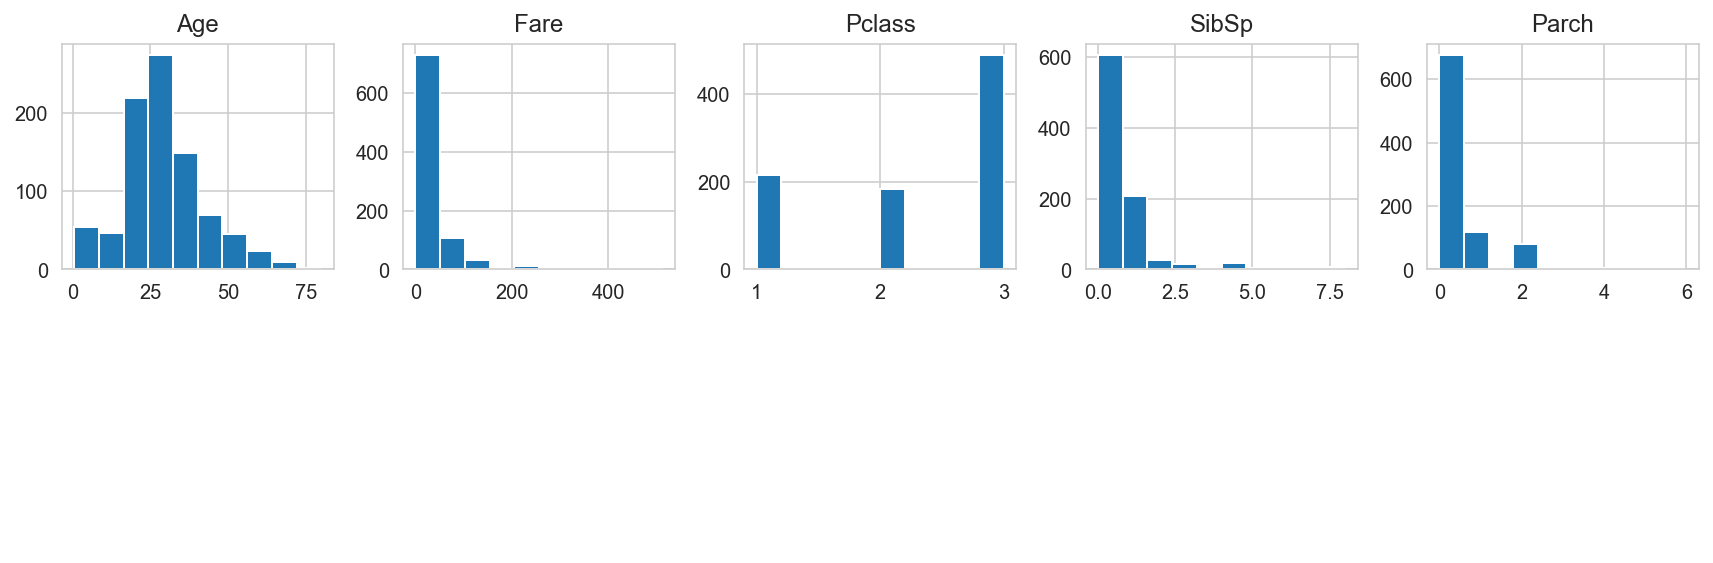

In [27]:
# build histograms for numeric nonbinary variables
fig, axList = plt.subplots(2, 5, sharex=False, sharey=False)
axList = axList.flatten()
fig.set_size_inches(12, 4)

for ax in axList[len(num_not_binary):]:
    ax.axis('off')

for i,ax in enumerate(axList[0:len(num_not_binary)]):
    train2.hist(column = num_not_binary[i], bins = 10, ax=ax)
            
fig.tight_layout()
fig.show()

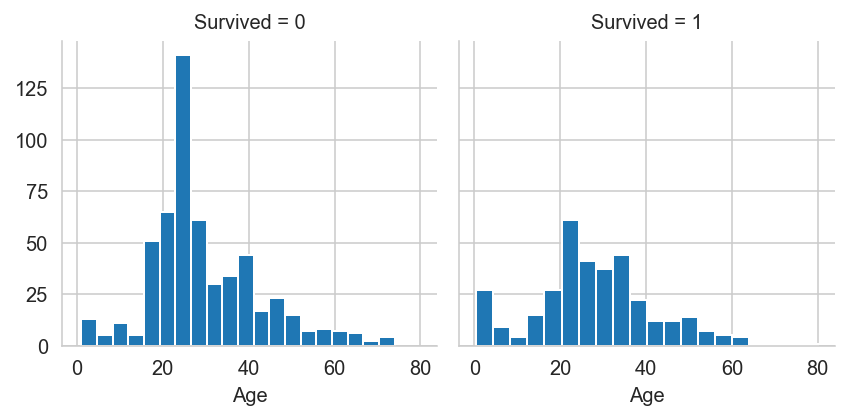

In [28]:


# look at age distribution vs survival
g = sns.FacetGrid(train2, col='Survived')
g.map(plt.hist, 'Age', bins=20)



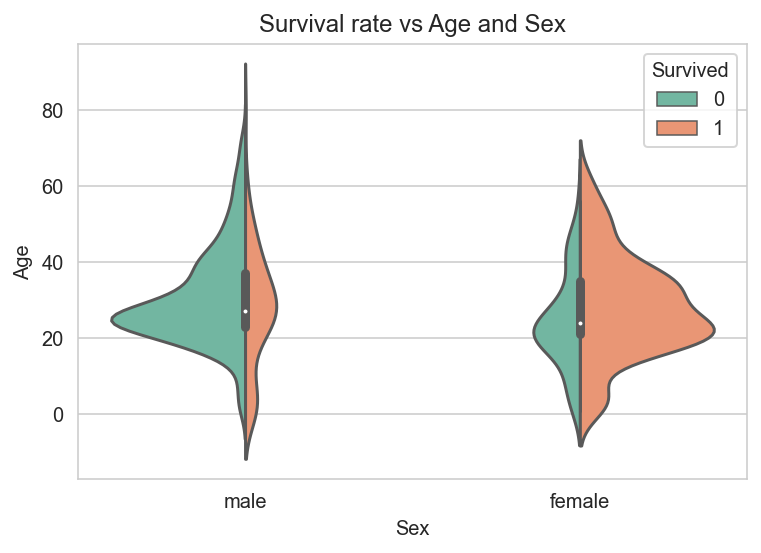

In [29]:
ax = sns.violinplot(x="Sex", y="Age", hue="Survived",
                    data=train1, palette="Set2", split=True,
                    scale="count")
ax.title.set_text('Survival rate vs Age and Sex')

For males:

    Age from 0 to about 12-15: more survived
    Age from 15: more didn't survive

For females:

    more survived at any age



## Preprocessing Data

In [30]:
# update lists of columns (numerical and categorical)
float_cols = train2.drop('PassengerId', axis=1).dtypes[train2.dtypes == 'float64'].index.tolist()
int_cols = train2.drop('PassengerId', axis=1).dtypes[train2.dtypes == 'int64'].index.tolist()
cat_cols = train2.drop('PassengerId', axis=1).dtypes[train2.dtypes == 'object'].index.tolist()
num_cols = float_cols + int_cols
binary = [x for x in num_cols if len(train2[x].unique()) == 2]
num_not_binary = [x for x in num_cols if x not in binary]

print("Numerical variables: ", num_cols)
print("Numerical continuous variables: ", float_cols)
print("Numerical discrete variables: ", int_cols)
print("Numerical and not binary variables: ", num_not_binary)
print("Binary variables: ", binary)
print("Categorical variables: ", cat_cols)

Numerical variables:  ['Age', 'Fare', 'Survived', 'Pclass', 'SibSp', 'Parch']
Numerical continuous variables:  ['Age', 'Fare']
Numerical discrete variables:  ['Survived', 'Pclass', 'SibSp', 'Parch']
Numerical and not binary variables:  ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']
Binary variables:  ['Survived']
Categorical variables:  ['Sex', 'Embarked']


In [31]:
target = ["Survived"]
features = [x for x in num_cols + cat_cols if x not in target]
cat_features = [x for x in features if x in cat_cols]
num_features = [x for x in features if x in num_cols]
print("Features: ", features)
print("Categorical features: ", cat_features)
print("Numerical features: ", num_features)



Features:  ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']
Categorical features:  ['Sex', 'Embarked']
Numerical features:  ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']


In [32]:
# get training data features and target
X = train2[features].copy()
y = train2[target].copy()
X.head()

,Age,Fare,Pclass,SibSp,Parch,Sex,Embarked
0,22.0,7.2500,3,1,0,male,S
1,38.0,71.2833,1,1,0,female,C
2,26.0,7.9250,3,0,0,female,S
3,35.0,53.1000,1,1,0,female,S
4,35.0,8.0500,3,0,0,male,S


In [33]:
y.value_counts(normalize=True)

Survived
0           0.616162
1           0.383838
dtype: float64

In [34]:
#The set is unbalanced, so I will add oversampling method to the estimator Pipeline.
X = pd.get_dummies(X, columns = cat_features, drop_first=True)
X.columns

Index(['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Sex_male', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [35]:


# split training data into train and test sets
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.4, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, y))

# Create the dataframes for train and test
X_train = X.loc[train_idx,]
y_train = y.loc[train_idx,]

X_test  = X.loc[test_idx,]
y_test  = y.loc[test_idx,]



In [36]:
# scale numeric columns
mm = MinMaxScaler()

for column in num_features:
    X_train[[column]] = mm.fit_transform(X_train[[column]])
    X_test[[column]] = mm.transform(X_test[[column]])

round(X_train.describe(), 3)

,Age,Fare,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
count,534.000,534.000,534.000,534.000,534.000,534.000,534.000,534.000
mean,0.368,0.062,0.658,0.055,0.063,0.644,0.084,0.708
std,0.168,0.097,0.417,0.114,0.138,0.479,0.278,0.455
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.259,0.015,0.500,0.000,0.000,0.000,0.000,0.000
50%,0.334,0.028,1.000,0.000,0.000,1.000,0.000,1.000
75%,0.472,0.059,1.000,0.125,0.000,1.000,0.000,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [37]:
round(X_test.describe(), 3)

,Age,Fare,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
count,357.000,357.000,357.000,357.000,357.000,357.000,357.000,357.000
mean,0.348,0.064,0.648,0.082,0.064,0.653,0.090,0.751
std,0.166,0.097,0.419,0.166,0.129,0.477,0.286,0.433
min,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.259,0.015,0.500,0.000,0.000,0.000,0.000,1.000
50%,0.309,0.030,1.000,0.000,0.000,1.000,0.000,1.000
75%,0.435,0.069,1.000,0.125,0.000,1.000,0.000,1.000
max,0.874,1.000,1.000,1.000,0.833,1.000,1.000,1.000


## Part 4 :  ML Classifiers
### Logistic Regression

In [38]:


# Logistic Regression
estimator_lr = Pipeline([#("feature_selector", KernelPCA(random_state = 42, kernel = 'rbf')),
                         #("clustering", FunctionTransformer(agg_cluster)),
                         ("sampling", ADASYN(sampling_strategy = 'minority', random_state = 42)),
                         ("clasifier", LogisticRegression(class_weight = 'balanced', solver='liblinear'))])

params_lr = {
    #'feature_selector__n_components': list(range(17, 22)),
    #'clustering__kw_args': [{'n_clusters': i} for i in range(3,8)],
    'sampling__n_neighbors': [4, 5, 6],
    'clasifier__penalty': ['l2'],
    'clasifier__C': np.geomspace(0.001, 40, 20)
}



In [39]:
# KFold for Grid Search
skf = StratifiedKFold(n_splits = 6)

# do grid search
grid_lr = GridSearchCV(estimator_lr, params_lr, 
                       scoring = 'f1', 
                       cv = skf, 
                       n_jobs = -1, verbose = 1)
grid_lr.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 60 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling',
                                        ADASYN(random_state=42,
                                               sampling_strategy='minority')),
                                       ('clasifier',
                                        LogisticRegression(class_weight='balanced',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clasifier__C': array([1.00000000e-03, 1.74668135e-03, 3.05089575e-03, 5.32894271e-03,
       9.30796486e-03, 1.62580486e-02, 2.83976304e-02, 4.96016115e-02,
       8.66382098e-02, 1.51329346e-01, 2.64324146e-01, 4.61690057e-01,
       8.06425413e-01, 1.40856823e+00, 2.46031986e+00, 4.29739482e+00,
       7.50617940e+00, 1.31109036e+01, 2.29005708e+01, 4.00000000e+01]),
                         'clasifier__penalty': ['l2'],
                         'sam

In [40]:
grid_lr.best_score_, grid_lr.best_params_

(0.7138344109210403,
 {'clasifier__C': 4.297394823041183,
  'clasifier__penalty': 'l2',
  'sampling__n_neighbors': 6})

In [41]:
# predict target values
y_pred_lr = grid_lr.predict(X_test)

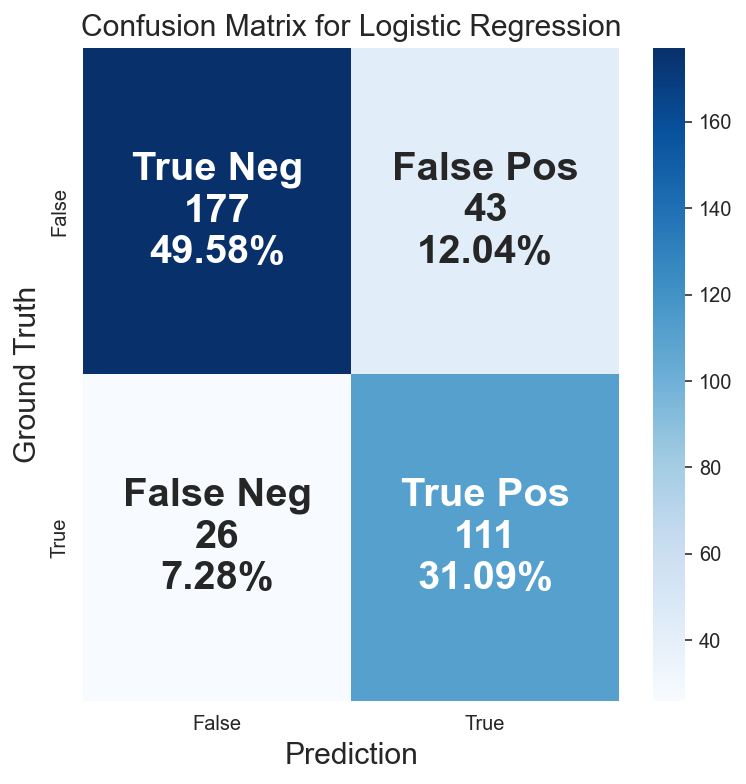

In [42]:
# Plot confusion matrix
c_matrix_lr = confusion_matrix(y_test, y_pred_lr)
vis_conf_matrix(c_matrix_lr, "Logistic Regression")

La matrice de confusion est en quelque sorte un résumé des résultats de prédiction pour un problème particulier de classification. Elle compare les données réelles pour une variable cible à celles prédites par un modèle. Les prédictions justes et fausses sont révélées et réparties par classe, ce qui permet de les comparer avec des valeurs définies.
Les résultats d'une matrice de confusion sont classés en quatre grandes catégories : les vrais positifs, les vrais négatifs, les faux positifs et les faux négatifs.

- Les vrais positifs ou TP (true positive) indiquent les cas où les prédictions et les valeurs réelles sont effectivement positives. Dans l'exemple fictif mentionné plus haut, cela signifie que le système reconnaît comme courrier pertinent un courrier qui l'est réellement.

- Les vrais négatifs ou TN (true negative) indiquent par contre les cas où les prédictions et les valeurs réelles sont toutes les deux négatives. Avec le même exemple, le test indique alors qu'un courrier donné est un spam, ce qui est bel et bien le cas.

- Les faux positifs ou FP (false positive) indiquent quant à eux une prédiction positive contraire à la valeur réelle qui est négative. Ils sont également considérés comme des erreurs de type 1. En poursuivant avec l'exemple, cela implique les cas où des spams sont considérés comme des courriers pertinents.

- Les faux négatifs font référence aux cas où les prédictions sont négatives alors que les valeurs réelles sont positives. Ils sont également considérés comme des erreurs de type 2. Dans le cas du système de courriers, cela désigne des courriers pertinents qui ont été classés parmi les spams.

In [43]:
print(classification_report(y_test, y_pred_lr))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_lr), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred_lr), 2))

              precision    recall  f1-score   support

           0       0.87      0.80      0.84       220
           1       0.72      0.81      0.76       137

    accuracy                           0.81       357
   macro avg       0.80      0.81      0.80       357
weighted avg       0.81      0.81      0.81       357

Accuracy score:  0.81
F1 Score:  0.76


### Les métriques

Différentes métriques peuvent être calculées à partir du tableau de contingence afin d'en faciliter l'interprétation. C'est par exemple le cas du taux d'erreur, de la précision, du rappel et du F1 score. Ces indicateurs permettent de mieux apprécier la qualité de précision du modèle.
Le taux d'erreur

- Le taux d'erreur ou ERR (error rate en anglais) est une métrique qui est calculée en faisant la somme de toutes les prédictions incorrectes sur le nombre total de données (positives et négatives). Plus il est bas, mieux c'est. Le meilleur taux d'erreur possible est de 0, mais il est rarement atteint par un modèle dans la pratique.

- Le taux d'erreur dans l'exemple des courriers représente la somme des nombres de courriers authentiques prédits comme spam et des spams reconnus comme courriers authentiques sur le nombre total de cas.

- Accuracy Ce paramètre fait la somme de tous les vrais positifs et vrais négatifs qu'il divise par le nombre total d'instances. Il permet d'apporter une réponse à la question suivante : de toutes les classes positives et négatives, combien parmi elles ont été prédites correctement ? Des valeurs élevées de ce paramètre sont souvent souhaitables. Il peut également être calculé avec la formule suivante :

Accuracy = 1 – ERR.


- La précision indique le rapport entre les prévisions positives correctes et le nombre total de prévisions positives. Ce paramètre répond donc à la question suivante : sur tous les enregistrements positifs prédits, combien sont réellement positifs ? En reprenant l'exemple des courriers, cela désigne le rapport entre le nombre de courriers pertinents reconnus comme tels (TP) par le modèle sur la somme combinée de ce même paramètre avec le nombre de spams considérés comme des courriers pertinents (FP).
Le rappel

- Le rappel (ou recall en anglais) est un paramètre qui permet de mesurer le nombre de prévisions positives correctes sur le nombre total de données positives. Il permet de répondre à la question suivante : sur tous les enregistrements positifs, combien ont été correctement prédits ? Dans l'exemple des courriers, cela représente le rapport entre le nombre de courriers pertinents reconnus comme tels sur le nombre réel de courriers pertinents. Celui-ci équivaut à la somme des vrais positifs (TP) et des faux négatifs (FN).

Pour ce système, le taux de rappel devrait dans l'idéal être de 100 %. Autrement dit, le nombre de faux négatifs devrait être égal à zéro. Il n'est en effet pas souhaitable que des courriers authentiques soient reconnus comme spams. Cela peut être très risqué. La métrique de rappel a donc une plus grande importance dans l'évaluation de la performance de ce système.

- Le score F1 (ou F-measure en anglais) est une moyenne harmonique de la précision et du rappel. Il équivaut au double du produit de ces deux paramètres sur leur somme. Sa valeur est maximale lorsque le rappel et la précision sont équivalents.

Dans certains modèles, on cherche à connaître la distribution des faux positifs et des faux négatifs. La métrique score F1 est alors utilisée pour évaluer la performance de l'algorithme. De même, il est particulièrement difficile de comparer deux modèles avec une faible précision et un rappel élevé. Le contraire est également vérifié. Dans ces conditions, le score F1 permet de mesurer ces deux paramètres simultanément.

In [44]:
scores = pd.DataFrame(data = {'model': ['logistic regression'], 
                              #'features': [grid_lr.best_params_['feature_selector__n_components']],  
                              'f1': [f1_score(y_test, y_pred_lr)], 
                              'accuracy': [accuracy_score(y_test, y_pred_lr)]})

scores.loc[scores.model == 'logistic regression', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_lr.ravel()/np.sum(c_matrix_lr)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,tn,fp,fn,tp
0,logistic regression,0.762887,0.806723,49.58,12.04,7.28,31.09


## Support Vector Machines

In [45]:
estimator_svc = Pipeline([#("clustering", FunctionTransformer(agg_cluster)),
                          ("feature_selector", KernelPCA(random_state = 42, kernel = 'rbf')),
                          ("sampling", ADASYN(sampling_strategy = 'minority', random_state = 42)),
                          ("clasifier", SVC(kernel = 'rbf', probability = True))])

params_svc = {#'clustering__kw_args': [{'n_clusters': i} for i in range(3,8)],
              'feature_selector__n_components': [16, 17],
              'sampling__n_neighbors': [5],
              'clasifier__gamma': np.geomspace(0.1, 4, 5), 
              'clasifier__C': np.geomspace(1, 50, 10)}

grid_svc = GridSearchCV(estimator_svc, params_svc, 
                       scoring = 'f1', 
                       cv=skf, 
                       n_jobs = -1, verbose = 1)

grid_svc.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 100 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('feature_selector',
                                        KernelPCA(kernel='rbf',
                                                  random_state=42)),
                                       ('sampling',
                                        ADASYN(random_state=42,
                                               sampling_strategy='minority')),
                                       ('clasifier', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'clasifier__C': array([ 1.        ,  1.5444521 ,  2.3853323 ,  3.6840315 ,  5.6898102 ,
        8.78763934, 13.57208808, 20.96144001, 32.37394014, 50.        ]),
                         'clasifier__gamma': array([0.1       , 0.25148669, 0.63245553, 1.59054146, 4.        ]),
                         'feature_selector__n_components': [16, 17],
                         'sampling__n_neighbors': [5]},
    

In [46]:
grid_svc.best_score_, grid_svc.best_params_

(0.7263685200107441,
 {'clasifier__C': 50.0,
  'clasifier__gamma': 4.0,
  'feature_selector__n_components': 17,
  'sampling__n_neighbors': 5})

In [47]:
# predict target values
y_pred_svc = grid_svc.predict(X_test)

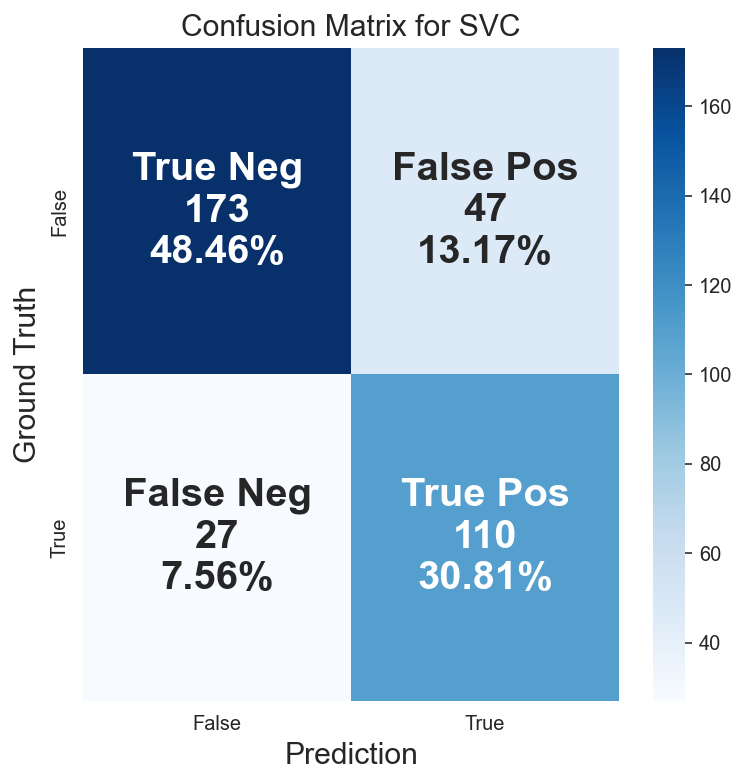

In [48]:
# Plot confusion matrix
c_matrix_svc = confusion_matrix(y_test, y_pred_svc)
vis_conf_matrix(c_matrix_svc, "SVC")

In [49]:
print(classification_report(y_test, y_pred_svc))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_svc), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred_svc), 2))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       220
           1       0.70      0.80      0.75       137

    accuracy                           0.79       357
   macro avg       0.78      0.79      0.79       357
weighted avg       0.80      0.79      0.79       357

Accuracy score:  0.79
F1 Score:  0.75


In [50]:
scores = scores.append({'model': 'SVC', 
                        #'features': grid_svc.best_params_['feature_selector__n_components'], 
                        'f1': f1_score(y_test, y_pred_svc),
                        'accuracy': accuracy_score(y_test, y_pred_svc)}, 
                        ignore_index=True)

scores.loc[scores.model == 'SVC', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_svc.ravel()/np.sum(c_matrix_svc)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,tn,fp,fn,tp
0,logistic regression,0.762887,0.806723,49.58,12.04,7.28,31.09
1,SVC,0.748299,0.792717,48.46,13.17,7.56,30.81


## K-Nearest Neighbors

In [52]:
# K-Nearest Neighbors
estimator_knn = Pipeline([("clustering", FunctionTransformer(agg_cluster)),
                          ("sampling", ADASYN(sampling_strategy = 'minority', random_state = 42)),
                          ("clasifier", KNeighborsClassifier())])

params_knn = {
    'clustering__kw_args': [{'n_clusters': i} for i in range(2,5)],
    'sampling__n_neighbors': [3, 4, 5],
    'clasifier__n_neighbors': [i for i in range(5, 10)], 
    'clasifier__weights': ['uniform'], 
    'clasifier__algorithm': ['auto'],
    'clasifier__p': [1, 2]
}

grid_knn = GridSearchCV(estimator_knn, params_knn, 
                       scoring = 'f1', 
                       cv=skf, 
                       n_jobs = -1, verbose = 1)

grid_knn.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 90 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('clustering',
                                        FunctionTransformer(func=<function agg_cluster at 0x000001D86E04F280>)),
                                       ('sampling',
                                        ADASYN(random_state=42,
                                               sampling_strategy='minority')),
                                       ('clasifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clasifier__algorithm': ['auto'],
                         'clasifier__n_neighbors': [5, 6, 7, 8, 9],
                         'clasifier__p': [1, 2],
                         'clasifier__weights': ['uniform'],
                         'clustering__kw_args': [{'n_clusters': 2},
                                                 {'n_clusters': 3},
                                                 {'n_clusters': 4}],
              

In [53]:
grid_knn.best_score_, grid_knn.best_params_

(0.7332732614816249,
 {'clasifier__algorithm': 'auto',
  'clasifier__n_neighbors': 9,
  'clasifier__p': 1,
  'clasifier__weights': 'uniform',
  'clustering__kw_args': {'n_clusters': 4},
  'sampling__n_neighbors': 4})

In [54]:


# predict target values
y_pred_knn = grid_knn.predict(X_test)



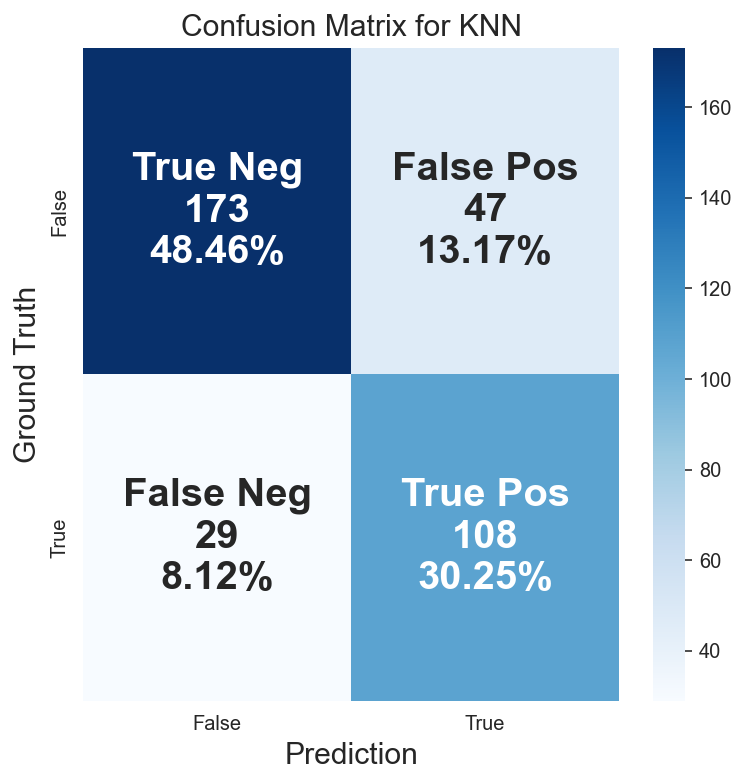

In [55]:
# Plot confusion matrix
c_matrix_knn = confusion_matrix(y_test, y_pred_knn)
vis_conf_matrix(c_matrix_knn, "KNN")

In [56]:

print(classification_report(y_test, y_pred_knn))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_knn), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred_knn), 2))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       220
           1       0.70      0.79      0.74       137

    accuracy                           0.79       357
   macro avg       0.78      0.79      0.78       357
weighted avg       0.80      0.79      0.79       357

Accuracy score:  0.79
F1 Score:  0.74


In [57]:
scores = scores.append({'model': 'KNN', 
                        #'features': grid_knn.best_params_['feature_selector__n_components'],  
                        'f1': f1_score(y_test, y_pred_knn),
                        'accuracy': accuracy_score(y_test, y_pred_knn)}, 
                        ignore_index=True)

scores.loc[scores.model == 'KNN', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_knn.ravel()/np.sum(c_matrix_knn)*100, 
                                                 decimals=2)
scores

,model,f1,accuracy,tn,fp,fn,tp
0,logistic regression,0.762887,0.806723,49.58,12.04,7.28,31.09
1,SVC,0.748299,0.792717,48.46,13.17,7.56,30.81
2,KNN,0.739726,0.787115,48.46,13.17,8.12,30.25


## Random Forest

In [58]:
# Random Forest Classifier
estimator_rf = Pipeline([#("feature_selector", KernelPCA(random_state = 42, kernel = 'rbf')),
                         #("clustering", FunctionTransformer(agg_cluster)),
                         ("sampling", ADASYN(sampling_strategy = 'minority', random_state = 42)),
                         ("clasifier", RandomForestClassifier(random_state = 42))])

params_rf = {#'feature_selector__n_components': [18, 19, 20],
             #'clustering__kw_args': [{'n_clusters': i} for i in range(2,8)],
             'sampling__n_neighbors': [3],
             'clasifier__n_estimators': [1000], 
             'clasifier__criterion': ['gini'], 
             'clasifier__bootstrap': [False],
             'clasifier__max_depth': [3],
             'clasifier__max_features': ['auto'],
             'clasifier__min_samples_leaf': [2, 3],
             'clasifier__min_samples_split': [3]}

# do grid search
grid_rf = GridSearchCV(estimator_rf, params_rf, 
                       scoring = 'f1', 
                       cv=skf, 
                       n_jobs = -1, verbose = 2)
grid_rf.fit(X_train, y_train.values.ravel())

Fitting 6 folds for each of 2 candidates, totalling 12 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('sampling',
                                        ADASYN(random_state=42,
                                               sampling_strategy='minority')),
                                       ('clasifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clasifier__bootstrap': [False],
                         'clasifier__criterion': ['gini'],
                         'clasifier__max_depth': [3],
                         'clasifier__max_features': ['auto'],
                         'clasifier__min_samples_leaf': [2, 3],
                         'clasifier__min_samples_split': [3],
                         'clasifier__n_estimators': [1000],
                         'sampling__n_neighbors': [3]},
             scoring='f1', verbose=2)

In [59]:
grid_rf.best_score_, grid_rf.best_params_

(0.7253103436547806,
 {'clasifier__bootstrap': False,
  'clasifier__criterion': 'gini',
  'clasifier__max_depth': 3,
  'clasifier__max_features': 'auto',
  'clasifier__min_samples_leaf': 2,
  'clasifier__min_samples_split': 3,
  'clasifier__n_estimators': 1000,
  'sampling__n_neighbors': 3})

In [60]:
# predict target values
y_pred_rf = grid_rf.predict(X_test)

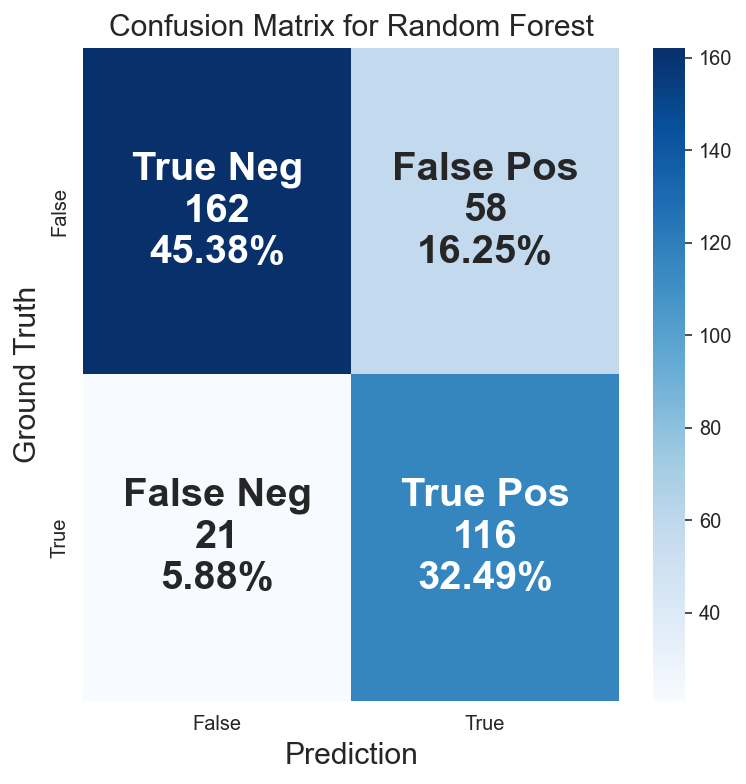

In [61]:
# Plot confusion matrix
c_matrix_rf = confusion_matrix(y_test, y_pred_rf)
vis_conf_matrix(c_matrix_rf, "Random Forest")

In [62]:
print(classification_report(y_test, y_pred_rf))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_rf), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred_rf), 2))

              precision    recall  f1-score   support

           0       0.89      0.74      0.80       220
           1       0.67      0.85      0.75       137

    accuracy                           0.78       357
   macro avg       0.78      0.79      0.77       357
weighted avg       0.80      0.78      0.78       357

Accuracy score:  0.78
F1 Score:  0.75


In [63]:


scores = scores.append({'model': 'random forest', 
                        #'features': grid_rf.best_params_['feature_selector__n_components'],   
                        'f1': f1_score(y_test, y_pred_rf),
                        'accuracy': accuracy_score(y_test, y_pred_rf)}, 
                        ignore_index=True)

scores.loc[scores.model == 'random forest', 
           ['tn', 'fp', 'fn', 'tp']] = np.around(c_matrix_rf.ravel()/np.sum(c_matrix_rf)*100, 
                                                 decimals=2)
scores



,model,f1,accuracy,tn,fp,fn,tp
0,logistic regression,0.762887,0.806723,49.58,12.04,7.28,31.09
1,SVC,0.748299,0.792717,48.46,13.17,7.56,30.81
2,KNN,0.739726,0.787115,48.46,13.17,8.12,30.25
3,random forest,0.745981,0.778711,45.38,16.25,5.88,32.49
